
Enron Classifier

Includes:
- Focal loss
- Early stopping
- Train/Val accuracy + loss as percentages


#Model

In [ ]:
%%capture
!pip install ipython-autotime
%load_ext autotime

time: 460 µs (started: 2025-06-08 11:50:10 +00:00)


In [ ]:
!pip install -q transformers
import pandas as pd
import numpy as np
import torch
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, get_scheduler
from torch.optim import AdamW
import torch.nn.functional as F

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


time: 35.4 s (started: 2025-06-08 11:50:10 +00:00)


In [ ]:
from google.colab import files, drive
drive.mount('/content/drive')
save_path = '/content/drive/MyDrive/DS Final Project/Subject Classification/BEST/enron_labeled_clean.csv'
df = pd.read_csv(save_path).dropna(subset=["content", "coarse_genre"])
df.head()

Mounted at /content/drive


,column_a,message_id,date,from,to,subject,x_from,x_to,x_cc,x_bcc,x_folder,x_origin,x_filename,content,user,labeled,coarse_genre,included_forwarded,primary_topic,emotional_tone
0,379,<9831685.1075855725804.JavaMail.evans@thyme>,2001-03-15T14:45:00,frozenset({'phillip.allen@enron.com'}),frozenset({'todd.burke@enron.com'}),Re: Confidential Employee Information/Lenhart,Phillip K Allen,Todd Burke,NaN,NaN,\Phillip_Allen_June2001\Notes Folders\'sent mail,Allen-P,pallen.nsf,I also need to know the base salaries of Jay R...,allen-p,True,Company Business / Strategy,NaN,Internal Operations,NaN
1,381,<21041312.1075855725847.JavaMail.evans@thyme>,2001-03-15T14:11:00,frozenset({'phillip.allen@enron.com'}),frozenset({'kim.bolton@enron.com'}),RE: PERSONAL AND CONFIDENTIAL COMPENSATION INF...,Phillip K Allen,Kim Bolton,NaN,NaN,\Phillip_Allen_June2001\Notes Folders\'sent mail,Allen-P,pallen.nsf,Thanks for the information. It would be helpfu...,allen-p,True,Personal in Work Context,NaN,NaN,Anxiety
2,2139,<5907100.1075858639941.JavaMail.evans@thyme>,2001-06-20T17:04:51,frozenset({'k..allen@enron.com'}),"frozenset({'matt.smith@enron.com', 'matthew.le...",FW: Western Wholesale Activities - Gas & Power...,"Allen, Phillip K. </O=ENRON/OU=NA/CN=RECIPIENT...","Lenhart, Matthew </O=ENRON/OU=NA/CN=RECIPIENTS...",NaN,NaN,"\PALLEN (Non-Privileged)\Allen, Phillip K.\Sen...",Allen-P,PALLEN (Non-Privileged).pst,"-----Original Message----- From: Hawkins, Bern...",allen-p,True,Logistics,Forwarded Emails + Replies,NaN,NaN
3,2140,<26625142.1075858639964.JavaMail.evans@thyme>,2001-06-20T17:09:00,frozenset({'k..allen@enron.com'}),"frozenset({'matt.smith@enron.com', 'matthew.le...",FW: Western Wholesale Activities - Gas & Power...,"Allen, Phillip K. </O=ENRON/OU=NA/CN=RECIPIENT...","Lenhart, Matthew </O=ENRON/OU=NA/CN=RECIPIENTS...",NaN,NaN,"\PALLEN (Non-Privileged)\Allen, Phillip K.\Sen...",Allen-P,PALLEN (Non-Privileged).pst,"-----Original Message----- From: Perrino, Dave...",allen-p,True,Logistics,Forwarded Emails + Replies,NaN,NaN
4,2232,<19730598.1075858642129.JavaMail.evans@thyme>,2001-08-09T12:30:58,frozenset({'k..allen@enron.com'}),"frozenset({'matt.smith@enron.com', 'm..tholt@e...",FW: Western Wholesale Activities - Gas & Power...,"Allen, Phillip K. </O=ENRON/OU=NA/CN=RECIPIENT...","Smith, Matt </O=ENRON/OU=NA/CN=RECIPIENTS/CN=M...",NaN,NaN,"\PALLEN (Non-Privileged)\Allen, Phillip K.\Sen...",Allen-P,PALLEN (Non-Privileged).pst,"-----Original Message----- From: Comnes, Alan ...",allen-p,True,Logistics,Forwarded Emails + Replies,NaN,NaN


time: 24.7 s (started: 2025-06-08 11:50:46 +00:00)


In [ ]:
df['coarse_genre'] = df['coarse_genre'].replace({'Purely Personal': 'Personal in Work Context'})
df = df[~df['coarse_genre'].isin(['Empty Message', 'Empty (attachment issue)'])]

label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['coarse_genre'])

print("Labels:", label_encoder.classes_)
texts = df['content'].tolist()
labels = df['label'].tolist()


Labels: ['Company Business / Strategy' 'Document Collaboration' 'Employment'
 'Logistics' 'Personal in Work Context']
time: 7.98 ms (started: 2025-06-08 11:51:11 +00:00)


<ipython-input-5-7cdaa27cb779>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = label_encoder.fit_transform(df['coarse_genre'])


In [ ]:

class EmailDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()} | {'labels': torch.tensor(self.labels[idx])}
    def __len__(self):
        return len(self.labels)


time: 803 µs (started: 2025-06-08 11:51:11 +00:00)


In [ ]:

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=SEED, stratify=labels
)
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=256)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=256)

train_dataset = EmailDataset(train_encodings, train_labels)
val_dataset = EmailDataset(val_encodings, val_labels)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

time: 1min 6s (started: 2025-06-08 11:51:11 +00:00)


In [ ]:

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(label_encoder.classes_))
model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=len(train_loader)*8)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


time: 20.6 s (started: 2025-06-08 11:52:17 +00:00)


In [ ]:

def focal_loss(logits, labels, alpha=1, gamma=2):
    ce_loss = F.cross_entropy(logits, labels, reduction='none')
    pt = torch.exp(-ce_loss)
    focal = alpha * (1 - pt) ** gamma * ce_loss
    return focal.mean()


time: 603 µs (started: 2025-06-08 11:52:38 +00:00)


In [ ]:

best_val_acc = 0
patience = 2
wait = 0

for epoch in range(8):
    model.train()
    total, correct = 0, 0
    train_loss = 0
    for batch in train_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        optimizer.zero_grad()
        outputs = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])
        loss = focal_loss(outputs.logits, batch['labels'])
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        train_loss += loss.item()
        preds = outputs.logits.argmax(dim=1)
        correct += (preds == batch['labels']).sum().item()
        total += batch['labels'].size(0)
    train_acc = correct / total * 100
    avg_train_loss = train_loss / len(train_loader)

    model.eval()
    total, correct = 0, 0
    val_loss = 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])
            loss = focal_loss(outputs.logits, batch['labels'])
            val_loss += loss.item()
            preds = outputs.logits.argmax(dim=1)
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(batch['labels'].cpu().tolist())
            correct += (preds == batch['labels']).sum().item()
            total += batch['labels'].size(0)
    val_acc = correct / total * 100
    avg_val_loss = val_loss / len(val_loader)

    print(f"🔁 Epoch {epoch+1} | 🏋️‍♀️ Train Acc: {train_acc:.2f}% | Train Loss: {avg_train_loss:.4f} | 🧪 Val Acc: {val_acc:.2f}% | Val Loss: {avg_val_loss:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        wait = 0
        torch.save(model.state_dict(), "best_model.pt")
    else:
        wait += 1
        if wait >= patience:
            print("⏹ Early stopping triggered.")
            break


🔁 Epoch 1 | 🏋️‍♀️ Train Acc: 58.16% | Train Loss: 0.6902 | 🧪 Val Acc: 62.12% | Val Loss: 0.5538
🔁 Epoch 2 | 🏋️‍♀️ Train Acc: 70.54% | Train Loss: 0.4668 | 🧪 Val Acc: 72.42% | Val Loss: 0.4548
🔁 Epoch 3 | 🏋️‍♀️ Train Acc: 79.35% | Train Loss: 0.3279 | 🧪 Val Acc: 71.52% | Val Loss: 0.4429
🔁 Epoch 4 | 🏋️‍♀️ Train Acc: 88.08% | Train Loss: 0.1866 | 🧪 Val Acc: 73.03% | Val Loss: 0.4141
🔁 Epoch 5 | 🏋️‍♀️ Train Acc: 90.66% | Train Loss: 0.1264 | 🧪 Val Acc: 76.06% | Val Loss: 0.4331
🔁 Epoch 6 | 🏋️‍♀️ Train Acc: 95.06% | Train Loss: 0.0741 | 🧪 Val Acc: 73.94% | Val Loss: 0.4463
🔁 Epoch 7 | 🏋️‍♀️ Train Acc: 96.36% | Train Loss: 0.0603 | 🧪 Val Acc: 74.24% | Val Loss: 0.4600
⏹ Early stopping triggered.
time: 7min 54s (started: 2025-06-08 11:52:38 +00:00)


Best Validation Accuracy: 76.06%
                             precision    recall  f1-score   support

Company Business / Strategy       0.82      0.81      0.81       148
     Document Collaboration       0.62      0.74      0.68        35
                 Employment       0.86      0.63      0.73        19
                  Logistics       0.77      0.73      0.75       102
   Personal in Work Context       0.42      0.50      0.46        26

                   accuracy                           0.74       330
                  macro avg       0.70      0.68      0.68       330
               weighted avg       0.75      0.74      0.75       330



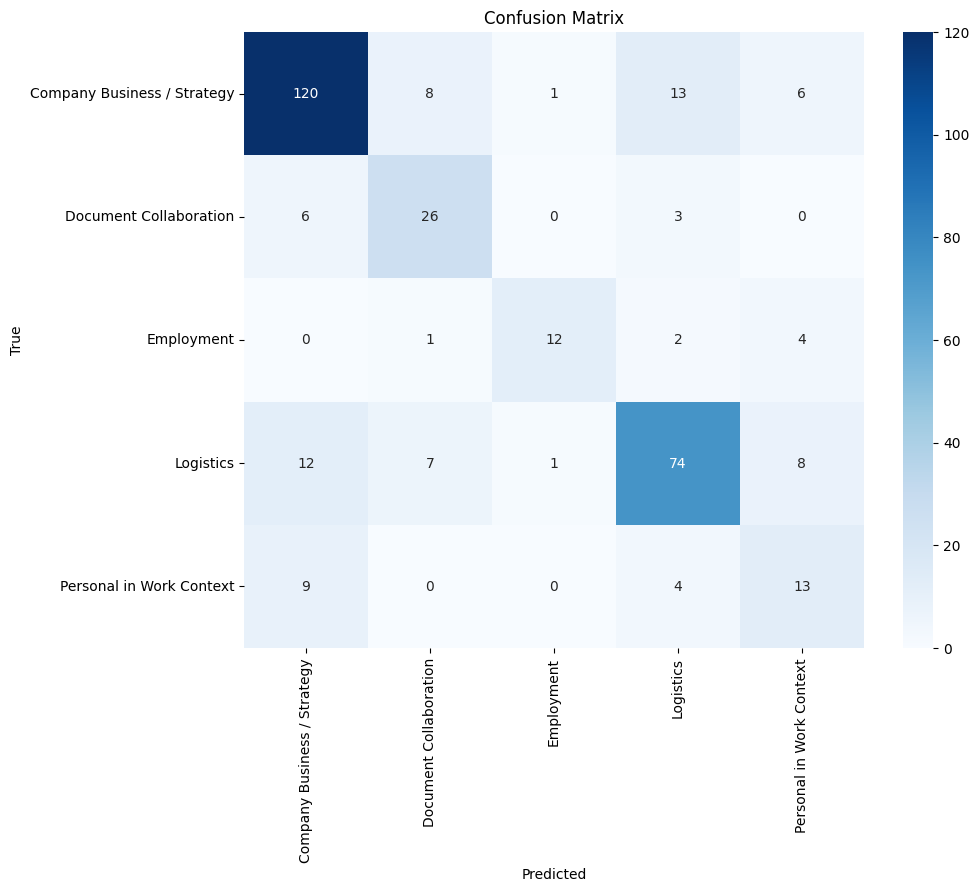

time: 437 ms (started: 2025-06-08 12:00:33 +00:00)


In [ ]:
print(f"Best Validation Accuracy: {best_val_acc:.2f}%")
print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


#Save

In [ ]:
# # Save only the model
# model.save_pretrained("bert_classifier_model")

# # Zip the model directory
# import shutil
# shutil.make_archive("bert_classifier_model", 'zip', "bert_classifier_model")

# # Download the zip file
# from google.colab import files
# files.download("bert_classifier_model.zip")


time: 320 µs (started: 2025-06-08 12:00:56 +00:00)


In [ ]:
# Save directly to Google Drive — no zip, no local copy
model.save_pretrained("/content/drive/MyDrive/DS Final Project/Subject Classification/BEST/subject_classifier_model")
tokenizer.save_pretrained("/content/drive/MyDrive/DS Final Project/Subject Classification/BEST/subject_classifier_model")

('/content/drive/MyDrive/DS Final Project/Subject Classification/BEST/subject_classifier_model/tokenizer_config.json',
 '/content/drive/MyDrive/DS Final Project/Subject Classification/BEST/subject_classifier_model/special_tokens_map.json',
 '/content/drive/MyDrive/DS Final Project/Subject Classification/BEST/subject_classifier_model/vocab.txt',
 '/content/drive/MyDrive/DS Final Project/Subject Classification/BEST/subject_classifier_model/added_tokens.json')

time: 11 s (started: 2025-06-08 12:00:56 +00:00)


#Benchmark

In [ ]:
# Mount Google Drive (if not already mounted)
drive.mount('/content/drive')

# Load the model and tokenizer from Drive
model_path = "/content/drive/MyDrive/DS Final Project/Subject Classification/BEST/subject_classifier_model"

model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer = BertTokenizer.from_pretrained(model_path)

# Put model on correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

time: 3.73 s (started: 2025-06-08 12:01:31 +00:00)


In [ ]:
drive.mount('/content/drive')
path = '/content/drive/MyDrive/DS Final Project/Subject Classification/BEST/synthetic_benchmark_balanced.csv'
benchmark_df = pd.read_csv(path)
benchmark_df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Subject,Body,coarse_genre
0,Re: House and Senate Energy Hearings Today on ...,I understand that we may have no choice in the...,Company Business / Strategy
1,Re: California Power Markets,We handed the Oped to DeLay's staff at lunch. ...,Company Business / Strategy
2,Re: House and Senate Energy Hearings Today on ...,"-----Original Message----- From: Novosel, Sara...",Company Business / Strategy
3,Re: House and Senate Energy Hearings Today on ...,Cindy - this looks like it might be an opportu...,Company Business / Strategy
4,Re: Duke release and news conference,"Please see the following articles: Sac Bee, Fr...",Company Business / Strategy


time: 2.71 s (started: 2025-06-08 12:01:35 +00:00)


In [ ]:
benchmark_df["content"] = benchmark_df["Subject"].fillna("") + " " + benchmark_df["Body"].fillna("")
benchmark_texts = benchmark_df["content"].tolist()

time: 3.62 ms (started: 2025-06-08 12:01:37 +00:00)


In [ ]:
# Encode with the tokenizer you used during training
benchmark_encodings = tokenizer(benchmark_texts, truncation=True, padding=True)

time: 6.74 s (started: 2025-06-08 12:01:37 +00:00)


In [ ]:
benchmark_labels = label_encoder.transform(benchmark_df["coarse_genre"])

time: 1.5 ms (started: 2025-06-08 12:01:44 +00:00)


In [ ]:
benchmark_dataset = EmailDataset(benchmark_encodings, benchmark_labels)
benchmark_loader = DataLoader(benchmark_dataset, batch_size=16)

time: 592 µs (started: 2025-06-08 12:01:44 +00:00)


In [ ]:
# model.eval()
all_preds = []

with torch.no_grad():
    for batch in benchmark_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)
        all_preds.extend(preds.cpu().numpy())

time: 15.2 s (started: 2025-06-08 12:01:44 +00:00)


                             precision    recall  f1-score   support

Company Business / Strategy       0.72      0.97      0.83       100
     Document Collaboration       0.98      0.87      0.92       100
                 Employment       0.99      0.92      0.95       100
                  Logistics       0.88      0.98      0.92       100
   Personal in Work Context       0.93      0.66      0.77       100

                   accuracy                           0.88       500
                  macro avg       0.90      0.88      0.88       500
               weighted avg       0.90      0.88      0.88       500



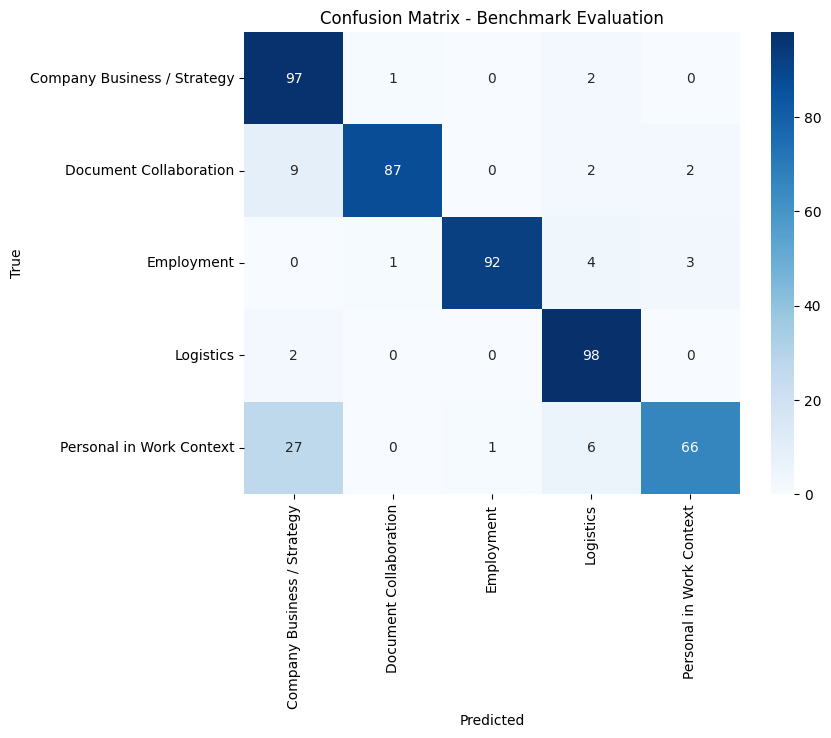

time: 308 ms (started: 2025-06-08 12:01:59 +00:00)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(benchmark_labels, all_preds, target_names=label_encoder.classes_))

# Compute confusion matrix
cm = confusion_matrix(benchmark_labels, all_preds)

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Benchmark Evaluation')
plt.show()


#Labeling

##Label sentence

In [ ]:
def classify_sentence(text):
    model.eval()
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        pred = torch.argmax(outputs.logits, dim=-1).item()
    label = label_encoder.inverse_transform([pred])[0]
    return label

time: 646 µs (started: 2025-06-08 12:02:42 +00:00)


In [ ]:
#your_sentence = "Please schedule a meeting about the Q4 business strategy."
#your_sentence = "Dear Jeff There aren't any 'corporate speak' words that can express what I feel, so I will use plain English: I am thrilled that I will be working for you at Enron."
#your_sentence = "Attached is the final letter"

predicted_label = classify_sentence(your_sentence)
print("Predicted label:", predicted_label)

Predicted label: Logistics
time: 24.4 ms (started: 2025-06-08 12:09:26 +00:00)


##Label csv

In [ ]:
def classify_csv(input_csv_path, subject_column="Subject", body_column="Body", output_csv_path="labeled_output.csv"):
    df = pd.read_csv(input_csv_path)
    df["content"] = df[subject_column].fillna("") + " " + df[body_column].fillna("")

    encodings = tokenizer(df["content"].tolist(), truncation=True, padding=True, return_tensors='pt')
    dataset = EmailDataset(encodings, [0]*len(df))  # Dummy labels

    loader = DataLoader(dataset, batch_size=16)
    preds = []

    model.eval()
    with torch.no_grad():
        for batch in loader:
            batch = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            outputs = model(**batch)
            pred_batch = torch.argmax(outputs.logits, dim=-1)
            preds.extend(pred_batch.cpu().numpy())

    df["predicted_label"] = label_encoder.inverse_transform(preds)
    df.to_csv(output_csv_path, index=False)
    print(f"Labeled CSV saved to: {output_csv_path}")


In [ ]:
csv_path_label = "/content/drive/MyDrive/DS Final Only Me/unseen_emails.csv"

classify_csv(csv_path_label)
files.download("labeled_output.csv")